In [ ]:
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from IPython.display import HTML
from torch.optim.lr_scheduler import StepLR
from scipy import linalg, stats
from torch.utils.data import DataLoader, TensorDataset, Subset
import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from torchsummary import summary
import matplotlib.animation as animation
from torch.distributions import Categorical

In [ ]:
# Note that we divide the batch size by 5, bc each "batch" contains 5 times more items bc of the five-fold transformation (see below)
batch_size = 128//5
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cpu')

In [ ]:
!pip3 install datasets
from datasets import load_from_disk
portrait_data = load_from_disk('/content/drive/MyDrive/cv2/wikiart_portrait')

In [ ]:
num_style_classes = len(set(portrait_data['style']))
original_indices = [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
consecutive_indices = {original_indices[i]: i for i in range(len(original_indices))}

'Rococo'

In [ ]:
from torchvision.transforms.functional import five_crop
from torchvision.transforms.functional import resize
from PIL import Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: five_crop(x, (int(x.shape[1]*0.9), int(x.shape[2]*0.9)))),
    transforms.Lambda(lambda crops: [resize(crop, (64, 64)) for crop in crops]),
    transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])),
])

def apply_transform(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    examples['style'] = [torch.stack([torch.tensor(consecutive_indices[style])]*5) for style in examples['style']]
    return examples

In [ ]:
ds = portrait_data.with_format("torch")
ds = portrait_data.with_transform(apply_transform)

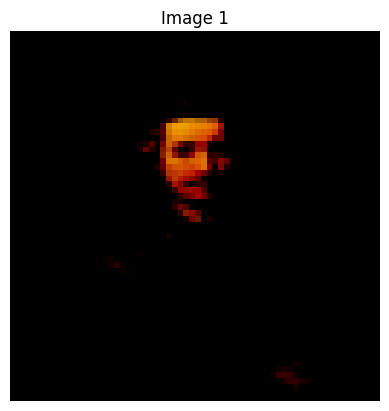

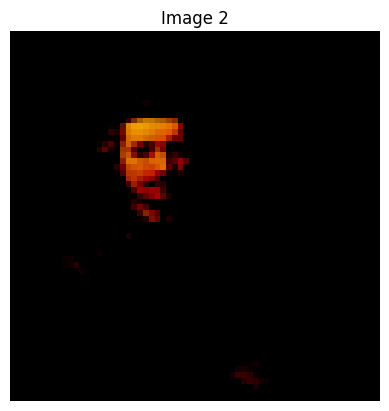

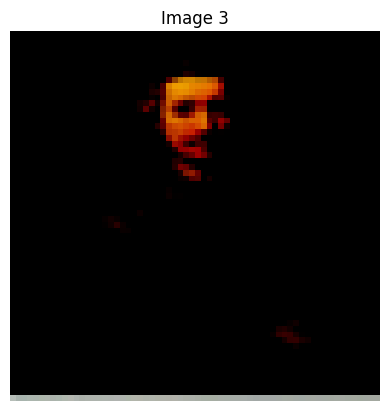

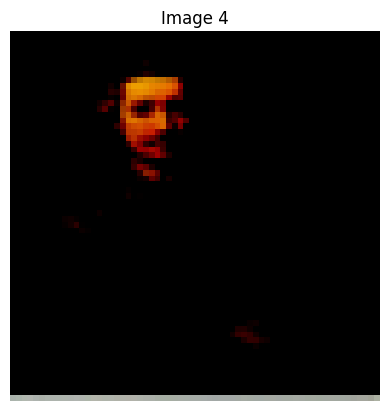

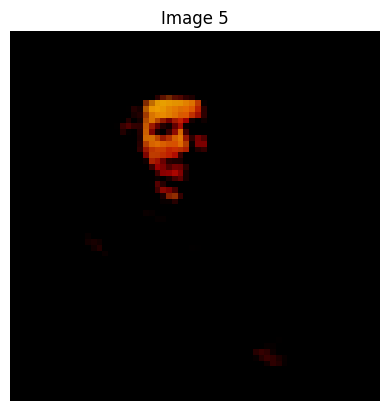

In [ ]:
import matplotlib.pyplot as plt
import torchvision

batch = ds[23]['image']

b = batch.size(0)

for i in range(b):
    image = batch[i].permute(1, 2, 0)

    image_np = image.cpu().numpy()

    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, num_style_classes=24):
        super(Generator, self).__init__()
        self.num_style_classes = num_style_classes
        self.style_embedding = nn.Embedding(num_style_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, style_label):
        style_emb = self.style_embedding(style_label)
        style_emb = style_emb.unsqueeze(2).unsqueeze(3).expand(-1, -1, input.size(2), input.size(3))
        input = torch.cat([input, style_emb], dim=1)
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, output_size=1, num_style_classes=24):
        super(Discriminator, self).__init__()
        self.num_style_classes = num_style_classes
        self.style_embedding = nn.Embedding(num_style_classes, nc)
        self.main = nn.Sequential(
            nn.Conv2d(nc + nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Real-fake head
        self.real_fake_head = nn.Sequential(
            nn.Conv2d(ndf * 8, output_size, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        # Multi-label head
        self.multi_label_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_style_classes),
            nn.Softmax()
        )

    def forward(self, x, style_label):
        style_emb = self.style_embedding(style_label)
        style_emb = style_emb.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, style_emb], dim=1)
        x = self.main(x)
        real_fake_output = self.real_fake_head(x)
        multi_label_output = self.multi_label_head(x)
        return real_fake_output.view(-1, 1), multi_label_output

latent_dim = 100
g = Generator()
batchsize = 2
style_label = torch.randint(0, num_style_classes, (batchsize,))
z = torch.randn(batchsize, latent_dim, 1, 1)
out = g(z, style_label)
print(out.size())

d = Discriminator()
x = torch.randn((batchsize, 3, 64, 64))
out = d(x, style_label)
print(out[0].size())
print(out[1].size())



torch.Size([2, 3, 64, 64])
torch.Size([2, 1])
torch.Size([2, 24])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["image"]))
        labels.append((example["style"]))
    pixel_values = torch.stack(images)
    labels = torch.cat(labels, dim=0)
    return {"image": pixel_values, "style": labels}

dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=batch_size)

In [ ]:
num_epochs = 1000
lr = 0.0001
beta1 = 0.5

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
criterion_rf = nn.BCELoss()
criterion_mc = nn.CrossEntropyLoss()

fixed_noise = torch.randn(batch_size, latent_dim ,1, 1, device=device)

real_label = 1.
fake_label = 0.

netD = Discriminator().to(device)
netD.apply(weights_init)
netG = Generator().to(device)
netG.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def image_entropy(probs):
    return sum(Categorical(probs = probs).entropy())/probs.size(0)

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch

        # real, label_mc = data
        real = data["image"].to(device)
        real = real.view(-1, real.size(2), real.size(3), real.size(4))

        label_mc = data["style"].to(device)

        b_size = real.size(0)

        # we have to repeat the class labels bc five_crop transformation creates five copies of the same image
        label_mc = label_mc.view(-1)

        label_rf = torch.full((b_size,), real_label, dtype=torch.float, device=device)


        # Forward pass real batch through D
        output_rf, output_mc = netD(real, label_mc)

        output_rf = output_rf.view(-1)
        # output_mc = output_mc.view(-1)

        # Calculate real/fake loss on all-real batch
        errD_real_rf = criterion_rf(output_rf, label_rf)
        # Calculate gradients for D in backward pass
        errD_real_rf.backward(retain_graph=True)

        # Calculate multiclass loss on all-real batch
        errD_real_mc = criterion_mc(output_mc, label_mc)
        # Calculate gradients for D, (summed) with previous gradients
        errD_real_mc.backward()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, label_mc)
        label_rf.fill_(fake_label)
        # Classify all fake batch with D
        output_rf, _ = netD(fake.detach(), label_mc)

        output_rf = output_rf.view(-1)

        # Calculate D's real/fake loss on the all-fake batch
        errD_fake_rf = criterion_rf(output_rf, label_rf)
        errD_fake_rf.backward()

        # Compute error of D as sum of the fake and the real batches for real/fake loss and the real multiclass loss
        errD = errD_real_rf + errD_fake_rf + errD_real_mc

        # Update D
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label_rf.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        output_rf, output_mc = netD(fake, label_mc)

        output_rf = output_rf.view(-1)
        # output_mc = output_mc.view(-1)


        # Calculate G's real/fake loss based on this output
        errG_rf = criterion_rf(output_rf, label_rf)
        # Calculate gradients for G
        errG_rf.backward(retain_graph=True)

        # Calculate G's mutliclass loss i.e. how good G is at making D struggle to categorize the generated art.
        # Note that we have a negative sign, as G wants this value to be large.
        # errG_mc = torch.tensor(b_size*np.log(used_labels), device=device) - image_entropy(output_mc)
        errG_mc = np.log(num_style_classes) - image_entropy(output_mc)

        errG_mc.backward()

        errG = errG_rf + errG_mc

        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))
            with open("/content/drive/MyDrive/4732_project/scaled_condcreative_bs_128.txt", "a+") as file:
              # Append the print statement
              file.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\n' %
                        (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))

    # Check if it's time to save the models
    if (epoch + 1) % 10 == 0:
        # Create a checkpoint dictionary containing the state dictionaries of the models
        checkpoint = {'netG': netG.state_dict(),
                      'netD': netD.state_dict()}

        # Save the checkpoint to a file with a name indicating the epoch
        torch.save(checkpoint, '/content/drive/MyDrive/4732_project/scaled_condcreative_bs_128_epoch_{}.pt'.format(epoch + 1))


Streaming output truncated to the last 5000 lines.
[25/1000][120/565]	Loss_D: 3.3223	Loss_G: 4.8940
[25/1000][130/565]	Loss_D: 3.1409	Loss_G: 5.1093
[25/1000][140/565]	Loss_D: 3.7391	Loss_G: 4.3323
[25/1000][150/565]	Loss_D: 4.6862	Loss_G: 5.2511
[25/1000][160/565]	Loss_D: 3.3714	Loss_G: 5.1946
[25/1000][170/565]	Loss_D: 3.2319	Loss_G: 5.1913
[25/1000][180/565]	Loss_D: 3.0111	Loss_G: 5.2175
[25/1000][190/565]	Loss_D: 3.8879	Loss_G: 4.1507
[25/1000][200/565]	Loss_D: 3.7089	Loss_G: 4.7912
[25/1000][210/565]	Loss_D: 3.0443	Loss_G: 5.7227
[25/1000][220/565]	Loss_D: 4.2232	Loss_G: 3.8912
[25/1000][230/565]	Loss_D: 3.6141	Loss_G: 4.3667
[25/1000][240/565]	Loss_D: 3.2036	Loss_G: 5.3329
[25/1000][250/565]	Loss_D: 3.3919	Loss_G: 4.3869
[25/1000][260/565]	Loss_D: 3.2937	Loss_G: 5.0299
[25/1000][270/565]	Loss_D: 3.4504	Loss_G: 4.6305
[25/1000][280/565]	Loss_D: 3.3283	Loss_G: 4.4855
[25/1000][290/565]	Loss_D: 3.9432	Loss_G: 3.9545
[25/1000][300/565]	Loss_D: 3.8562	Loss_G: 4.5568
[25/1000][310/565]